In [1]:
import rasterio
import numpy as np

# Data Source - https://github.com/globalmaps/gm_ve_v1
forests_file = rasterio.open('../resources/data/downsampled_forest.tif')
forests = forests_file.read()

print(np.amin(forests))
print(np.amax(forests))
print(len(np.unique(forests)))



0
100
101


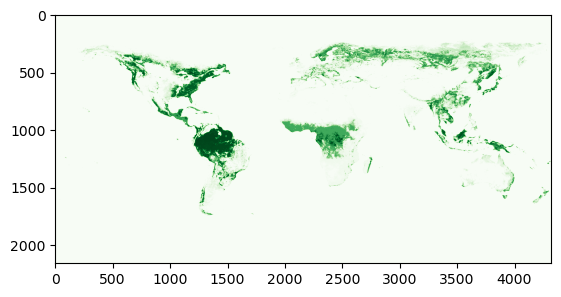

<AxesSubplot:>

In [2]:
from rasterio.plot import show
import matplotlib.pyplot as plt

show(forests, cmap='Greens')

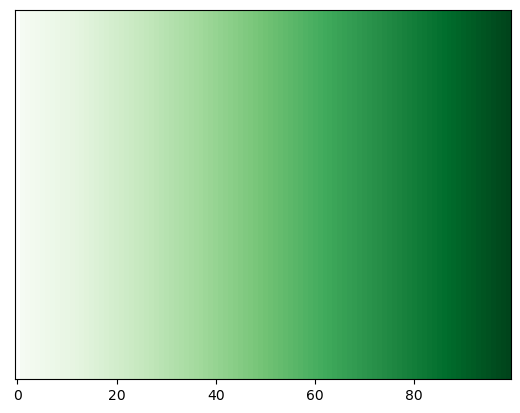

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

greens = cm.get_cmap('Greens', 100)
newcolors = greens(np.linspace(0, 1, 100))
newcolors[:1, :] = np.array([0.0, 0.0, 0.0, 0.0])
newcmp_forests = ListedColormap(newcolors)

bounds = np.arange(100)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)

gradient = np.vstack((np.linspace(0, 1, 100), np.linspace(0, 1, 100)))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=newcmp_forests)
ax.get_yaxis().set_visible(False)

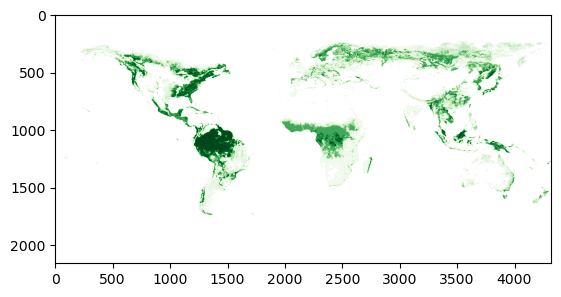

<AxesSubplot:>

In [4]:
show(forests, cmap=newcmp_forests, norm=norm_forests)

In [5]:
import rioxarray as rxr
from rasterio.crs import CRS
import numpy as np

# Load raster and squeeze singleton dimensions
forests_file_rxa = rxr.open_rasterio('../resources/data/downsampled_forest.tif', masked=True).squeeze()

print("Original projection: ", forests_file_rxa.rio.crs)

# Reproject to new CRS
forests = forests_file_rxa.rio.reproject(CRS.from_string('+proj=robin'))

print("New projection: ", forests.rio.crs)

# Convert to NumPy array
forests_np = forests.to_numpy()

# Mask nodata values and set them to zero
nodata_value = np.finfo(np.float32).max  # 3.4028235e+38
forests_np[forests_np == nodata_value] = 0

Original projection:  EPSG:4326
New projection:  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## Exercise

- Plot the reprojected raster
- Pick a new - interesting projection and reproject your raster to that. 

<img src="../resources/forests_rob.png">

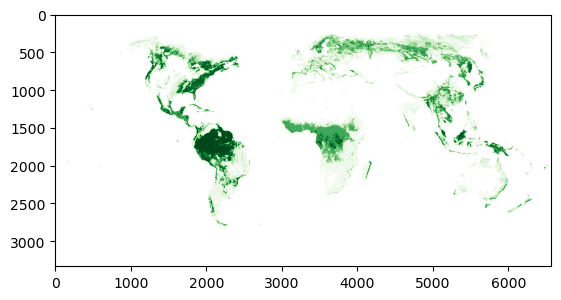

<AxesSubplot:>

In [6]:
show(forests_np, cmap=newcmp_forests, norm=norm_forests)

<AxesSubplot:>

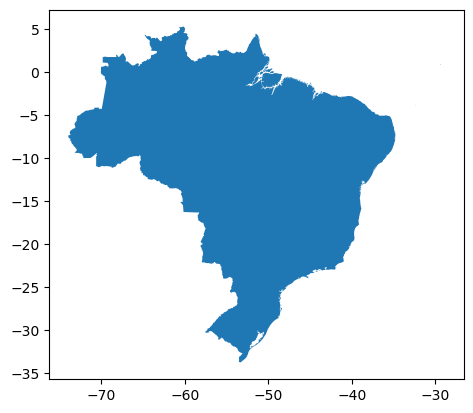

In [7]:
import geopandas as gpd
import pandas as pd

# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('../resources/data/ne_10m_admin_0_countries.shp')

brazil = df.loc[df['ADMIN'] == 'Brazil']
brazil.plot()

In [8]:
import rasterio
from rasterio import mask as msk 
from shapely.geometry import mapping

clipped_array_forests, clipped_transform_forests = rasterio.mask.mask(forests_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)

## Exercise 

- Plot the forests map of Brazil. 
- Use the topography dataset - ../resources/downsampled_topography.tif and generate a topography map of a country.

In [9]:
topography_file = rasterio.open('../resources/data/downsampled_topography.tif')

clipped_array_topo, clipped_transform_topo = rasterio.mask.mask(topography_file, [mapping(geom) for geom in (brazil.geometry.tolist())], 
                                                      crop=True, nodata=0)

gnuplot = cm.get_cmap('gnuplot', 2002)
newcolors = gnuplot(np.linspace(0, 1, 2002))
newcolors[:1, :] = np.array([0.0, 0.0, 0.0, 0.0])
newcmp_topo = ListedColormap(newcolors)
bounds = np.arange(2002)
norm_topo = BoundaryNorm(bounds, newcmp_topo.N)

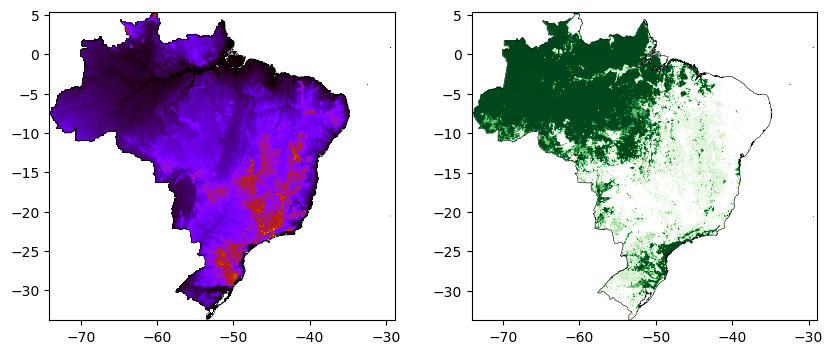

In [10]:
# Plot raster
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

show(clipped_array_topo, ax=ax1, transform=clipped_transform_topo, cmap=newcmp_topo, norm=norm_topo)
brazil.boundary.plot(ax=ax1, edgecolor='black',  lw=0.4)

show(clipped_array_forests, ax=ax2, transform=clipped_transform_forests, cmap=newcmp_forests, norm=norm_forests)
brazil.boundary.plot(ax=ax2, edgecolor='black',  lw=0.4)

plt.show()

In [11]:
from rasterio.io import MemoryFile

memfile = MemoryFile()
dataset = memfile.open(driver='GTiff', height=clipped_array_forests.shape[1], width=clipped_array_forests.shape[2], 
                       count=1, crs=forests_file.crs, 
                       transform=clipped_transform_forests, dtype=clipped_array_forests.dtype)
dataset.write(clipped_array_forests[0], 1)

In [12]:
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

# Define the destination CRS - Mercator projection
dst_crs = 'EPSG:3395'

# Calculate the transform and dimensions for the new projection
transform, width, height = calculate_default_transform(dataset.crs, dst_crs, dataset.width, dataset.height, *dataset.bounds)

# Create a destination numpy array
dst_array = np.empty((height, width), dtype=clipped_array_forests.dtype)

# Perform the reprojection
reproject(
    source=rasterio.band(dataset, 1),
    destination=dst_array,
    src_transform=dataset.transform,
    src_crs=dataset.crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 Affine(9471.839736281423, 0.0, -8246918.942934983,
        0.0, -9471.839736281423, 590594.3686729408))

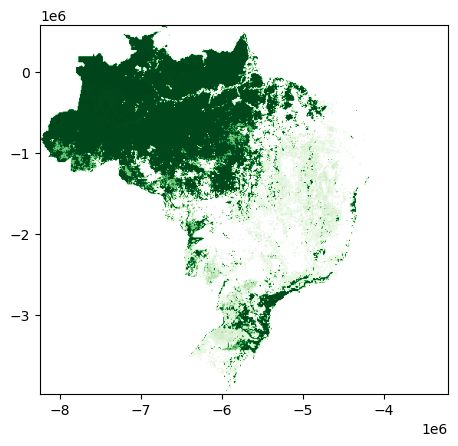

<AxesSubplot:>

In [13]:
show(dst_array, transform=transform, cmap=newcmp_forests, norm=norm_forests)


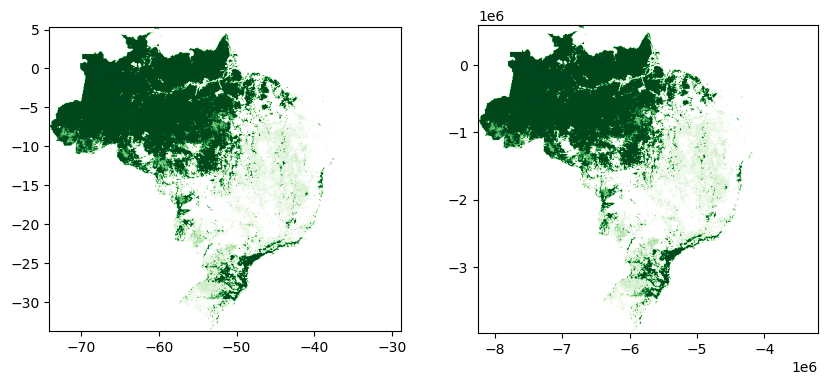

In [14]:
# Plot raster
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

show(clipped_array_forests, ax=ax1, transform=clipped_transform_forests, cmap=newcmp_forests, norm=norm_forests)

show(dst_array, ax=ax2, transform=transform, cmap=newcmp_forests, norm=norm_forests)

plt.show()

## Exercise 

- Plot both the rivers from the previous exercise and forests from this exercise on the same map. 
- Try out different projections - but make sure all datasets have the same projection.

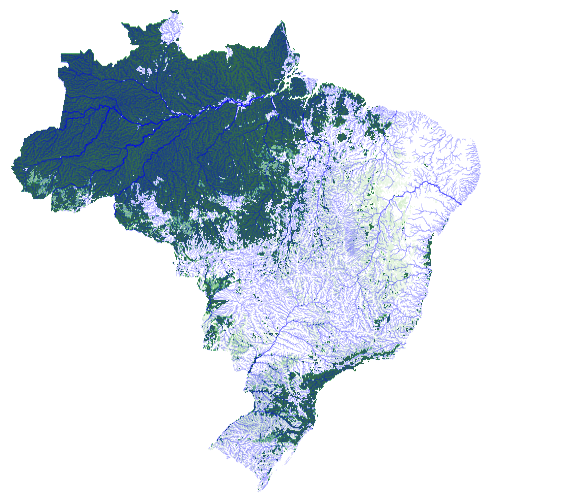

In [15]:
samerica_rivers = gpd.read_parquet("../resources/data/rivers.parquet.gzip")

leftSpan = np.amax(samerica_rivers['DIST_UP_KM']) - np.amin(samerica_rivers['DIST_UP_KM'])
rightSpan = 1 - 0.1
valueScaled = (samerica_rivers['DIST_UP_KM'] - np.amin(samerica_rivers['DIST_UP_KM'])) / leftSpan
samerica_rivers['LW_DIST_UP_KM'] = 0.1 + (valueScaled * rightSpan)

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
show(clipped_array_forests, ax=ax, transform=clipped_transform_forests, cmap=newcmp_forests, norm=norm_forests, alpha=0.8)
samerica_rivers.plot(ax=ax, edgecolor='face', color='blue', lw=samerica_rivers['LW_DIST_UP_KM'])
ax.axis('off')
plt.show()